# Trying a Neural Network to predict the rest-eigen part from the eigen-eigen part

In [54]:
using LmaPredict, Flux, Statistics, ProgressMeter

## Reading the data

In [55]:
const path_config = "/Users/lukasgeyer/Studium/Computational Sciences/Masterarbeit/Daten Simon/dat"
const path_plot = "../plots"

"../plots"

In [56]:
fname = readdir(path_config)[2:5001]
idx = sortperm( parse.(Int64, fname))
fname = fname[idx]

cnfgarr = Vector{LMAConfig}(undef, 0)
for f in fname
    push!(cnfgarr, get_LMAConfig(joinpath(path_config, f), "g5-g5", em="PA", bc=false))
end

## Splitting data in training and test sets

In [57]:
# Select a specific Tsource and divide data into training and test set for eigenvalues, rr re and ee components
TSRC = "0"
NCNFG = length(cnfgarr)
TVALS = length(cnfgarr[1].data["rr"][TSRC]) - 1
EIGVALS = 32

eigvals_data = Array{Float32}(undef, EIGVALS, 500)
rr_data = Array{Float32}(undef, TVALS, 500)
ee_data = Array{Float32}(undef, TVALS, 500)
re_data = Array{Float32}(undef, TVALS, 500)

eigvals_data_test = Array{Float32}(undef, EIGVALS, 4500)
rr_data_test = Array{Float32}(undef, TVALS, 4500)
ee_data_test = Array{Float32}(undef, TVALS, 4500)
re_data_test = Array{Float32}(undef, TVALS, 4500)

for (k, dd) in enumerate(getfield.(cnfgarr, :data)[1:500])
    eigvals_data[:,k] = copy(cnfgarr[k].data["eigvals"][1:EIGVALS])
    rr_data[:,k] = getindex(getindex(dd, "rr"), TSRC)[2:end]
    ee_data[:,k] = getindex(getindex(dd, "ee"), TSRC)[2:end]
    re_data[:,k] = getindex(getindex(dd, "re"), TSRC)[2:end]
end
for (k, dd) in enumerate(getfield.(cnfgarr, :data)[501:5000])
    eigvals_data_test[:,k] = copy(cnfgarr[k].data["eigvals"][1:EIGVALS])
    rr_data_test[:,k] = getindex(getindex(dd, "rr"), TSRC)[2:end]
    ee_data_test[:,k] = getindex(getindex(dd, "ee"), TSRC)[2:end]
    re_data_test[:,k] = getindex(getindex(dd, "re"), TSRC)[2:end]
end

## Describing the Neural Network

As input we choose a vector containing the inverted eigenvalues $\{\lambda_i\}$ as the first $n_{\lambda}$ entries, followed by the $n_{ee}$ eigen-eigen contributions $\{ee_i\}$:



$v_{input} = \begin{bmatrix} \ \frac{1}{\lambda_1} \ \\[6pt] \ \frac{1}{\lambda_2} \ \\[6pt] \ \frac{1}{\lambda_3} \ \\[6pt] \vdots \\[6pt] \frac{1}{\lambda_{n_{\lambda}}} \\[6pt]
 \ ee_1 \ \\[6pt] \ ee_2 \ \\[6pt]\ ee_3 \ \\[6pt] \vdots \\[6pt]\ ee_{n_{ee}} \ \end{bmatrix}$

 where $n_{ee}$ is the number of time samples, 47 in our case, $n_{\lambda}$ is either 32 or 64, depending of which configuration type ("PA" or "VV") is used. $\\[10pt]$

Our Neural Network therefore has an input layer of size $n_{\lambda} + n_{ee}$. We then try one fully connected layer of size $2(n_{\lambda} + n_{ee})$ and a fully connected output layer of size $n_{ee}$. 

In [58]:
input_length = TVALS + EIGVALS
output_length = TVALS
hidden_length = 2 * input_length

input_data = vcat(1 ./ eigvals_data, ee_data) ./ 10
target = re_data 

test_input_data = (vcat(1 ./ eigvals_data_test, ee_data_test) .-  mean([sum(vcat(1 ./ eigvals_data, ee_data)[:,i])/input_length for i in 1:500])) ./ 10
test_target = re_data_test;

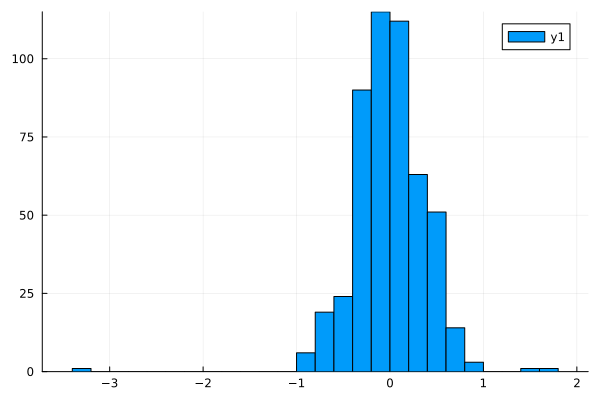

In [59]:
using Plots

histogram([sum(test_input_data[:,i])/input_length for i in 1:500])

## Defining the Network

In [60]:
model = Chain(
    Dense(input_length => hidden_length, tanh),
    Dense(hidden_length => hidden_length, tanh),
    Dense(hidden_length => hidden_length, tanh),
    Dense(hidden_length => output_length, NNlib.tanhshrink),
    ) 

Chain(
  Dense(79 => 158, tanh),               # 12_640 parameters
  Dense(158 => 158, tanh),              # 25_122 parameters
  Dense(158 => 158, tanh),              # 25_122 parameters
  Dense(158 => 47, tanhshrink),         # 7_473 parameters
)                   # Total: 8 arrays, 70_357 parameters, 275.332 KiB.

## Defining training input and target data

In [61]:
loader = Flux.DataLoader((input_data, target), batchsize=32, shuffle=true)

optim = Flux.setup(Flux.Adam(0.001), model);

## Training the Network

The network sees the whole data set **epochs** times. As loss function we use Mean Squared Error.

In [62]:
epochs = 10_000

losses = []
@showprogress for epoch in 1:epochs
    for (x, y) in loader
        loss, grads = Flux.withgradient(model) do m
            y_hat = m(x)
            Flux.mse(y_hat, y)
        end
        Flux.update!(optim, model, grads[1])
        push!(losses, loss) 
    end
end

Progress: 100%|█████████████████████████████████████████| Time: 0:01:34


## Checking loss dynamics during training

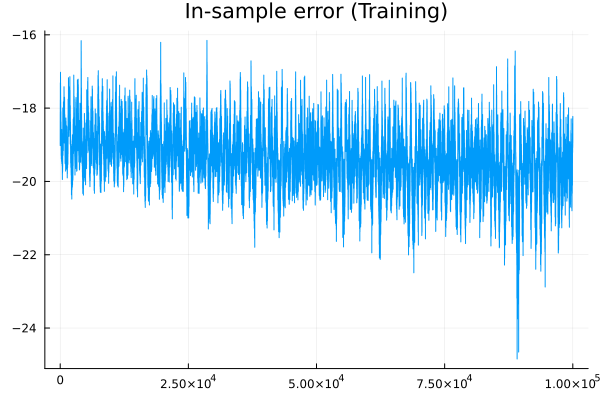

In [63]:
using Plots

plot(log.(losses[end-100000:end] .- minimum(losses)), title="In-sample error (Training)", legend=:false)

## Checking out-of-sample results

maximum error: 2.892692e-6
minimum error: 5.5705748e-8
average error: 5.215932e-7


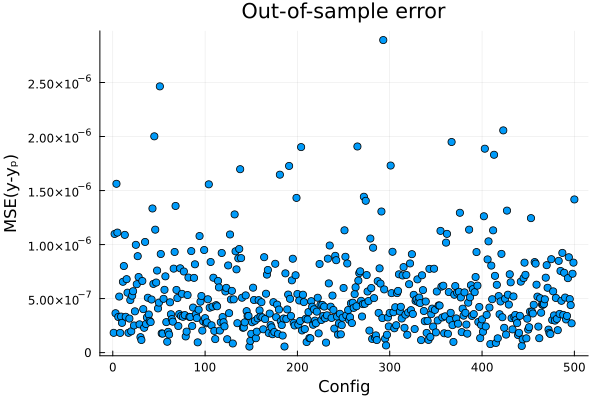

In [72]:
out_of_sample_predictions = model(test_input_data)
out_of_sample_error = [Flux.mse(out_of_sample_predictions[:,i], test_target[:,i]) for i in 1:500]

println("maximum error: ", maximum(out_of_sample_error))
println("minimum error: ", minimum(out_of_sample_error))
println("average error: ", mean(out_of_sample_error))

scatter(out_of_sample_error, title="Out-of-sample error", legend=:false)
xlabel!("Config")
ylabel!("MSE(y-yₚ)")

Current best perfomance:

maximum error: 1.4382569458100352e-6

minimum error: 2.3611581318928464e-8

average error: 2.9356580255092587e-7

with this model:

model = Chain(
    Dense(input_length => hidden_length, tanh),
    BatchNorm(hidden_length),
    Dense(hidden_length => output_length, tanh),
    softmax
    ) 

In [73]:
using Plots

l = @layout [a b c; d e f; g h i]

c1 = rand([i for i in 1:500])
p1 = scatter(test_target[:,c1], label="Actual")
scatter!(p1, out_of_sample_predictions[:,c1], label="Prediction", legend=:top)

c2 = rand([i for i in 1:500])
p2 = scatter(test_target[:,c2], label="Actual")
scatter!(p2, out_of_sample_predictions[:,c2], label="Prediction", legend=:top)

c3 = rand([i for i in 1:500])
p3 = scatter(test_target[:,c3], label="Actual")
scatter!(p3, out_of_sample_predictions[:,c3], label="Prediction", legend=:top, )

c4 = rand([i for i in 1:500])
p4 = scatter(test_target[:,c4], label="Actual")
scatter!(p4, out_of_sample_predictions[:,c4], label="Prediction", legend=:top)

c5 = rand([i for i in 1:500])
p5 = scatter(test_target[:,c5], label="Actual")
scatter!(p5, out_of_sample_predictions[:,c5], label="Prediction", legend=:top)

c6 = rand([i for i in 1:500])
p6 = scatter(test_target[:,c6], label="Actual")
scatter!(p6, out_of_sample_predictions[:,c6], label="Prediction", legend=:top)

c7 = rand([i for i in 1:500])
p7 = scatter(test_target[:,c7], label="Actual")
scatter!(p7, out_of_sample_predictions[:,c7], label="Prediction", legend=:top)

c8 = rand([i for i in 1:500])
p8 = scatter(test_target[:,c8], label="Actual")
scatter!(p8, out_of_sample_predictions[:,c8], label="Prediction", legend=:top)

c9 = rand([i for i in 1:500])
p9 = scatter(test_target[:,c9], label="Actual")
scatter!(p9, out_of_sample_predictions[:,c9], label="Prediction", legend=:top)

plot(p1, p2, p3, p4, p5, p6, p7, p8, p9, layout = l, size=(1200,1000), dpi=1000, markerstrokewidth = 0)
#savefig(joinpath(path_plot, "neural_network_test.pdf"))

# Bias correction

### Calculating statistical errors

In [78]:
re_mean = [sum(test_target[i,:]) / 4500 for i in 1:47]
re_predicted_mean = [sum(out_of_sample_predictions[i,:]) / 4500 for i in 1:47]

re_err = [sqrt(sum( (test_target[i,:] .- re_mean[i]).^2 / 4499 )) for i in 1:47] ./ sqrt(4500)
re_predicted_err = [sqrt(sum( (out_of_sample_predictions[i,:] .- re_mean[i]).^2 / 4499 )) for i in 1:47] ./ sqrt(4500);

### Applying bias correction on a percentage of the test data

In [79]:
percentage = 0.04

n_configs = Int(4500 * percentage)

configs = rand([i for i in 1:4500], n_configs)

bias_correction = sum([re_predicted_mean - test_target[:,i] for i in configs][i] for i in 1:n_configs) ./ n_configs

re_predicted_mean_corrected = re_predicted_mean - bias_correction;

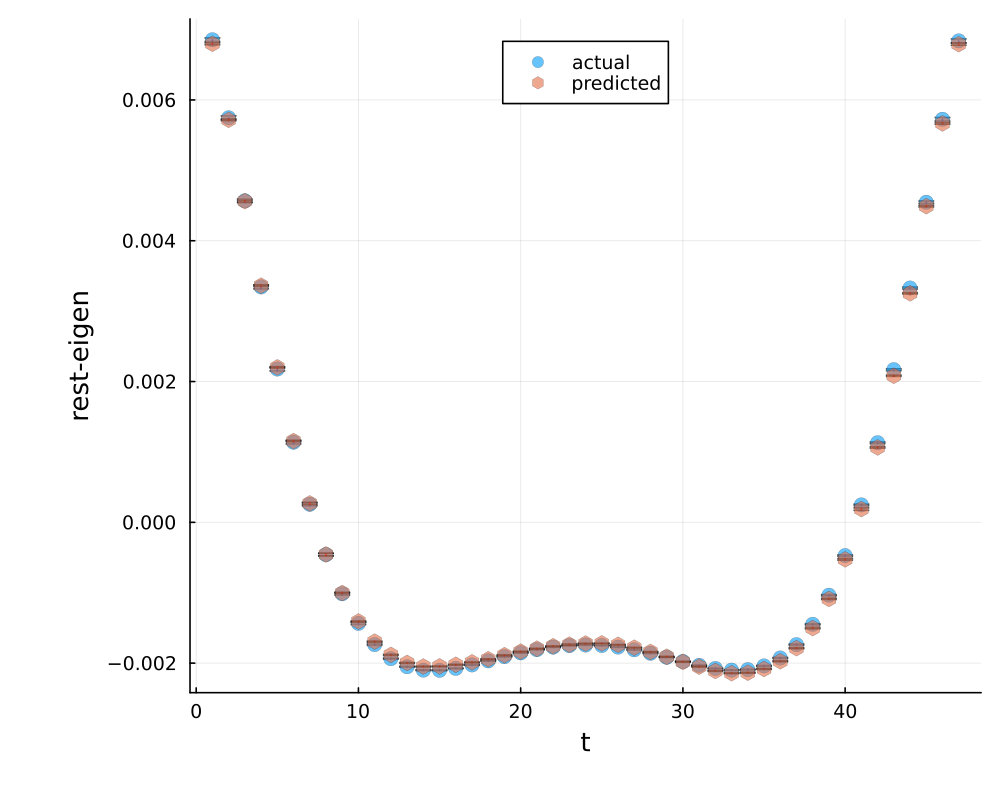

In [80]:
using Plots

p = plot(size=(1000,800),thickness_scaling = 1.6)
scatter!(p,re_mean,
    yerr=re_err,
    label="actual",
    legend=:top,
    line=(:dot, 1),
    linecolor=:blue,
    markerstrokewidth = 0.1,
    markersize = 5,
    markeralpha = 0.6
)
scatter!(p,re_predicted_mean_corrected,
    yerr=re_predicted_err,
    label="predicted",
    marker = ([:hex :d]),
    line = (:dot, 1),
    linecolor=:red,
    markerstrokewidth = 0.1,
    markersize = 5,
    markeralpha = 0.6
)
xlabel!(p,"t")
ylabel!(p,"rest-eigen")